#### Epithelial cell states labels transfer from gut healthy adult single-cell RNA sequencing cells to Xenium add-on panel data with `scANVI`
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 20th March 2024

##### Import packages

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Setup working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [5]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [6]:
input = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/scRNA_and_Xenium_add_on_data_scANVI.h5ad'
adata = sc.read_h5ad(input)

In [7]:
X_is_raw(adata)

True

+ Prepare observations column

In [9]:
# Convert 'Cell Type' to object type temporarily
adata.obs['Cell Type'] = adata.obs['Cell Type'].astype('object')

# Perform the copy operation
adata.obs.loc[adata.obs['Cell Type'].isnull(), 'Cell Type'] = adata.obs['C_scANVI']

# Optional: Convert 'Cell Type' back to categorical, if needed
adata.obs['Cell Type'] = adata.obs['Cell Type'].astype('category')


In [10]:
adata.obs['Cell Type'].value_counts()

Epithelial      256088
Mesenchymal      99311
Plasma cells     65526
T cells          51200
Myeloid          43438
Endothelial      24289
B cells          21217
Neuronal         10941
Name: Cell Type, dtype: int64

+ Extract epithelial cells

In [11]:
adata = adata[adata.obs['Cell Type'] == 'Epithelial']

In [12]:
adata.obs['seed_labels'] = adata.obs['Cell States'].copy()

In [13]:
adata.obs['seed_labels'].cat.categories

Index(['BEST2+ Goblet cell', 'BEST4+ epithelial', 'Colonocyte',
       'D cells (SST+)', 'EC cells (TAC1+)', 'EECs', 'Enterochromaffin cells',
       'Enterocyte', 'Enterocytes BEST4', 'Enterocytes CA1 CA2 CA4-',
       'Enterocytes TMIGD1 MEP1A', 'Enterocytes TMIGD1 MEP1A GSTA1',
       'Enteroendocrine cells', 'Epithelial Cycling cells',
       'Epithelial HBB HBA', 'Epithelial cells METTL12 MAFB', 'Goblet cell',
       'Goblet cells MUC2 TFF1', 'Goblet cells MUC2 TFF1-',
       'Goblet cells SPINK4', 'I cells (CCK+)', 'K cells (GIP+)', 'L cells',
       'L cells (PYY+)', 'M/X cells (MLN/GHRL+)', 'Microfold cell',
       'N cells (NTS+)', 'Paneth', 'Paneth cells', 'Progenitor (NEUROG3+)',
       'Stem cells OLFM4', 'Stem cells OLFM4 GSTA1', 'Stem cells OLFM4 LGR5',
       'Stem cells OLFM4 PCNA', 'Stem_Cells_GCA', 'Stem_Cells_ext', 'TA',
       'Tuft', 'Tuft cells'],
      dtype='object')

+ Make cell states more categorized

In [14]:
goblet = ["BEST2+ Goblet cell", "Goblet cell", 'Goblet cells MUC2 TFF1', 'Goblet cells MUC2 TFF1-', 'Goblet cells SPINK4']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(goblet, 'Goblet_cells')

epithelial = ['BEST4+ epithelial', 'Epithelial Cycling cells',
       'Epithelial HBB HBA', 'Epithelial cells METTL12 MAFB']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(epithelial, 'Epithelial_cells')

stem = ['Stem cells OLFM4', 'Stem cells OLFM4 GSTA1', 'Stem cells OLFM4 LGR5',
       'Stem cells OLFM4 PCNA', 'Stem_Cells_GCA', 'Stem_Cells_ext']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(stem, 'Stem_cells')  

enterocytes = ['Enterocyte', 'Enterocytes BEST4', 'Enterocytes CA1 CA2 CA4-','Enterocytes TMIGD1 MEP1A', 'Enterocytes TMIGD1 MEP1A GSTA1']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(enterocytes, 'Enterocytes') 

adata.obs['seed_labels'] = adata.obs['seed_labels'].replace('Tuft', 'Tuft cells')  

adata.obs['seed_labels'] = adata.obs['seed_labels'].replace('Paneth', 'Paneth cells')  

In [15]:
enteroendocrine = ['EC cells (TAC1+)', 'EECs', 'D cells (SST+)', 'I cells (CCK+)', 'K cells (GIP+)', 'L cells',
       'L cells (PYY+)', 'M/X cells (MLN/GHRL+)', 'N cells (NTS+)']
adata.obs['seed_labels'] = adata.obs['seed_labels'].replace(enteroendocrine, 'Enteroendocrine cells')

In [16]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].cat.add_categories('Unknown')
adata.obs.loc[adata.obs['seed_labels'].isnull(), 'seed_labels'] = 'Unknown'

In [ ]:
#Create a barplot of the number of cells per cell type in the epithelial_cells_fetal object
plt.figure(figsize = (20, 10))
plt.bar(adata.obs["seed_labels"].value_counts().index, adata.obs["seed_labels"].value_counts(), color = "blue", edgecolor = "black", linewidth = 1.2)
plt.xticks(rotation = 90, fontsize = 12)

+ Run scVI

In [18]:
adata.layers['counts'] = adata.X.copy()

In [19]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Donor_ID', 
                                                          'Library_Preparation_Protocol', 
                                                          'Study_name'],
                              labels_key = "seed_labels", 
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [20]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [21]:
scvi_model.train(30, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████| 30/30 [04:47<00:00,  8.62s/it, v_num=1, train_loss_step=114, train_loss_epoch=113]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████| 30/30 [04:47<00:00,  9.59s/it, v_num=1, train_loss_step=114, train_loss_epoch=113]


In [22]:
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

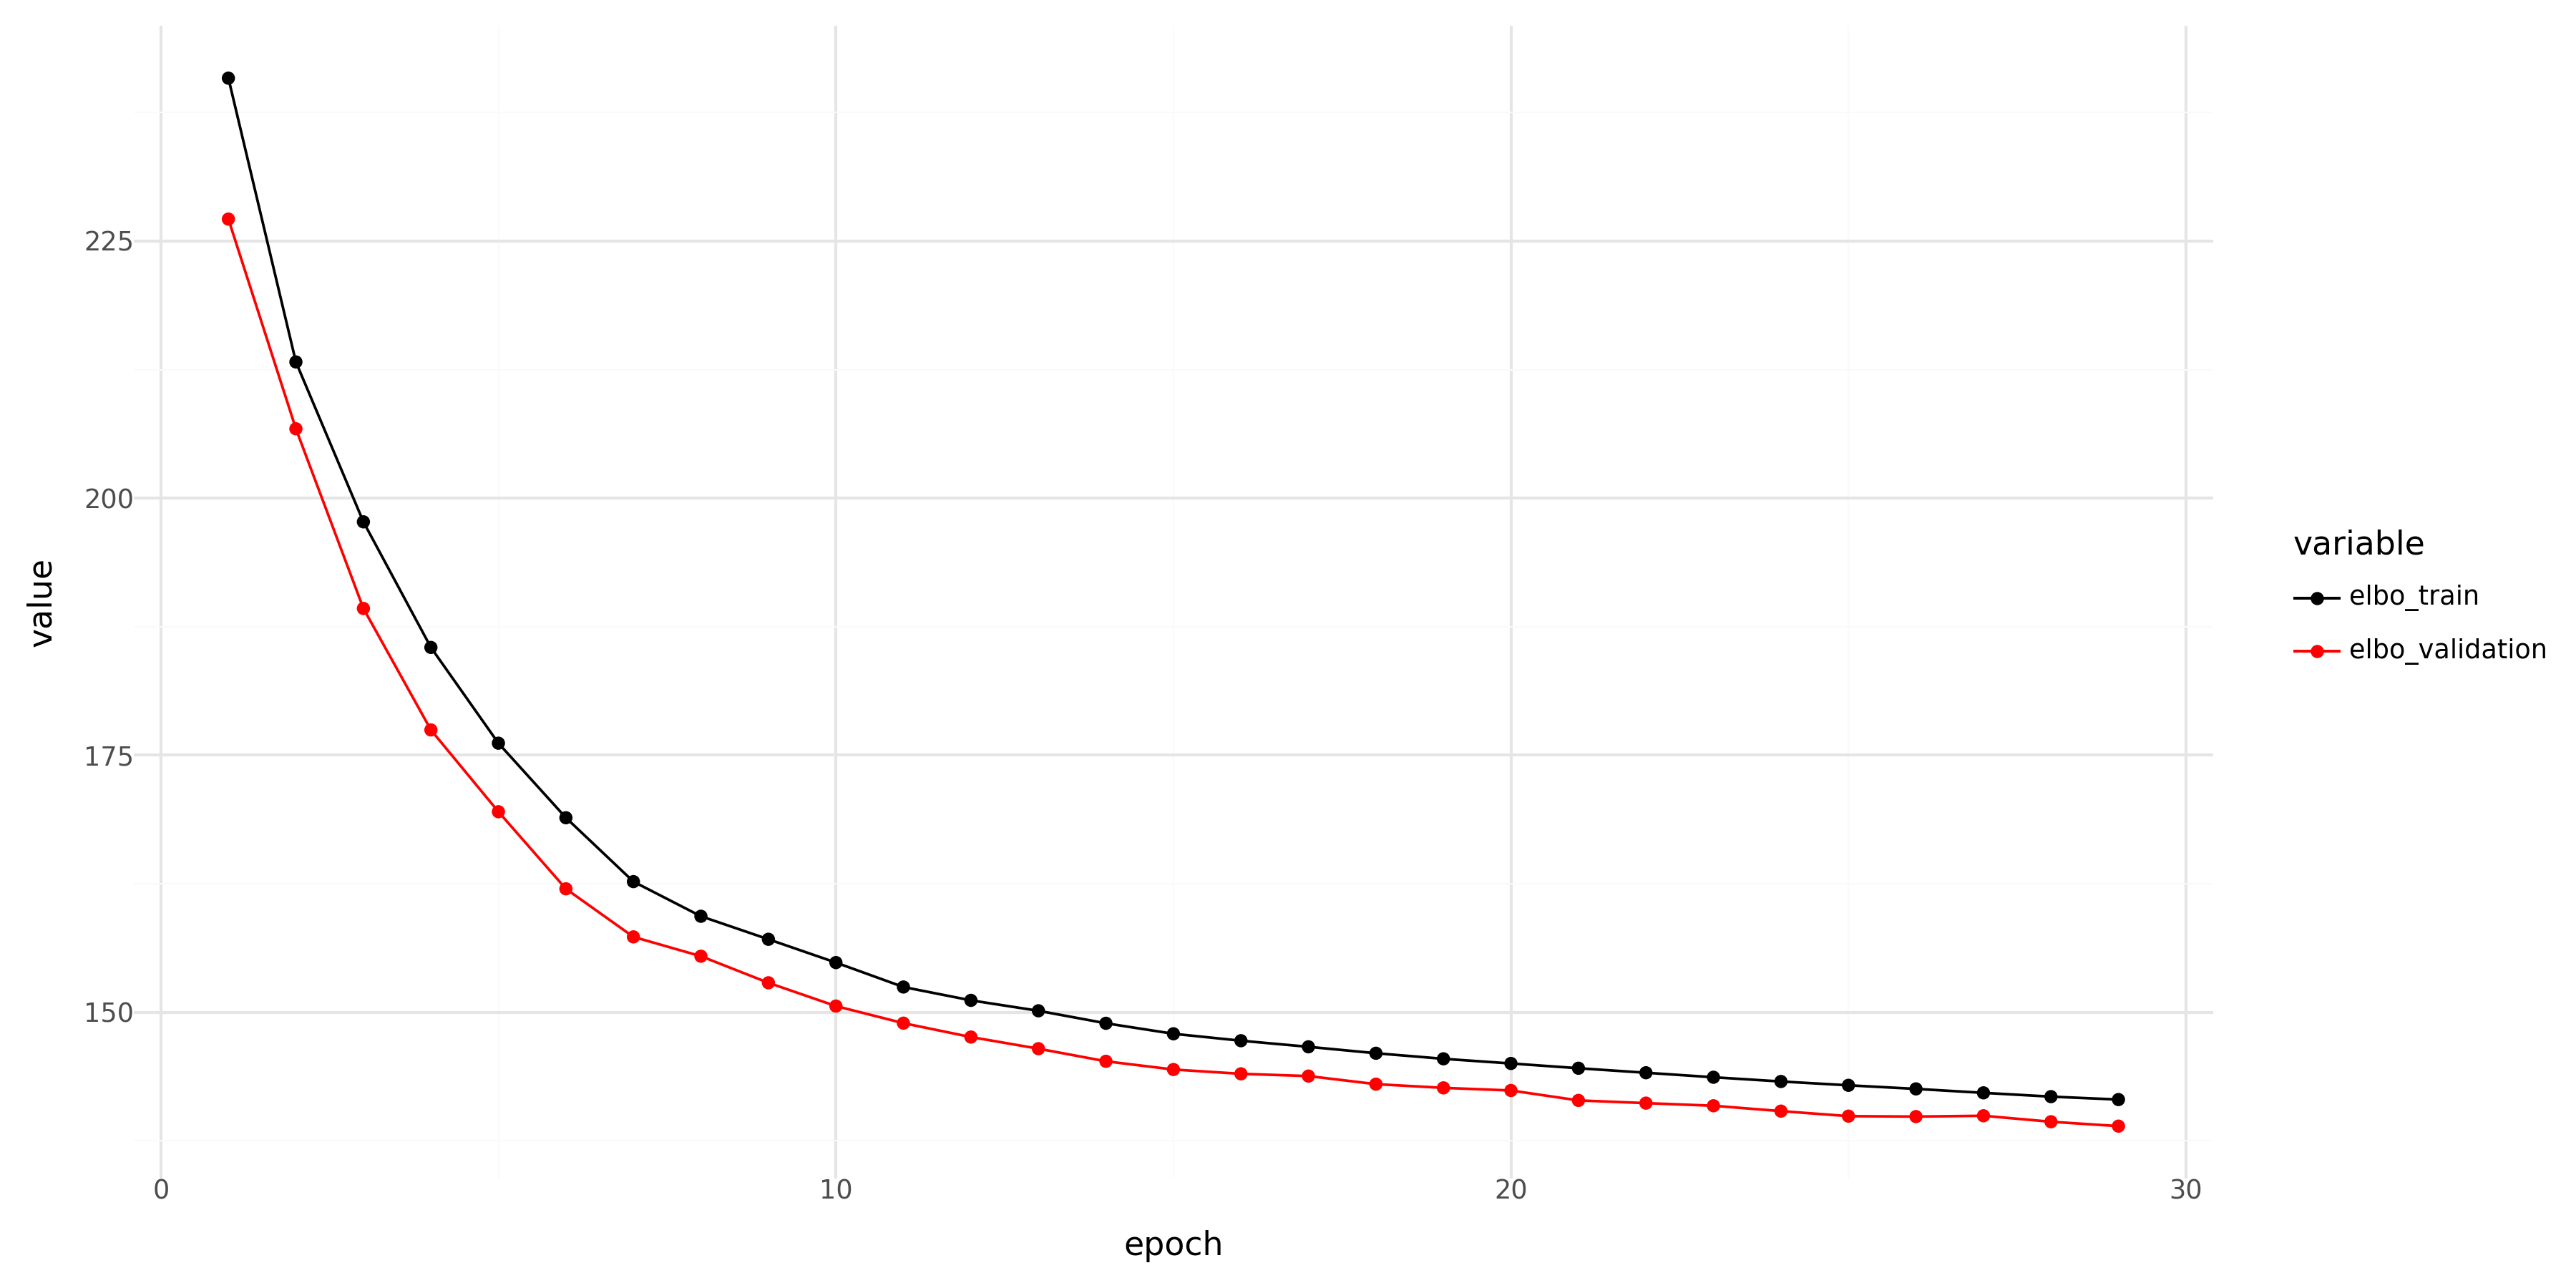

In [23]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [24]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [25]:
scanvi_model.train(50, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [0])

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 50/50 [19:32<00:00, 22.01s/it, v_num=1, train_loss_step=132, train_loss_epoch=121]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 50/50 [19:32<00:00, 23.44s/it, v_num=1, train_loss_step=132, train_loss_epoch=121]


In [26]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

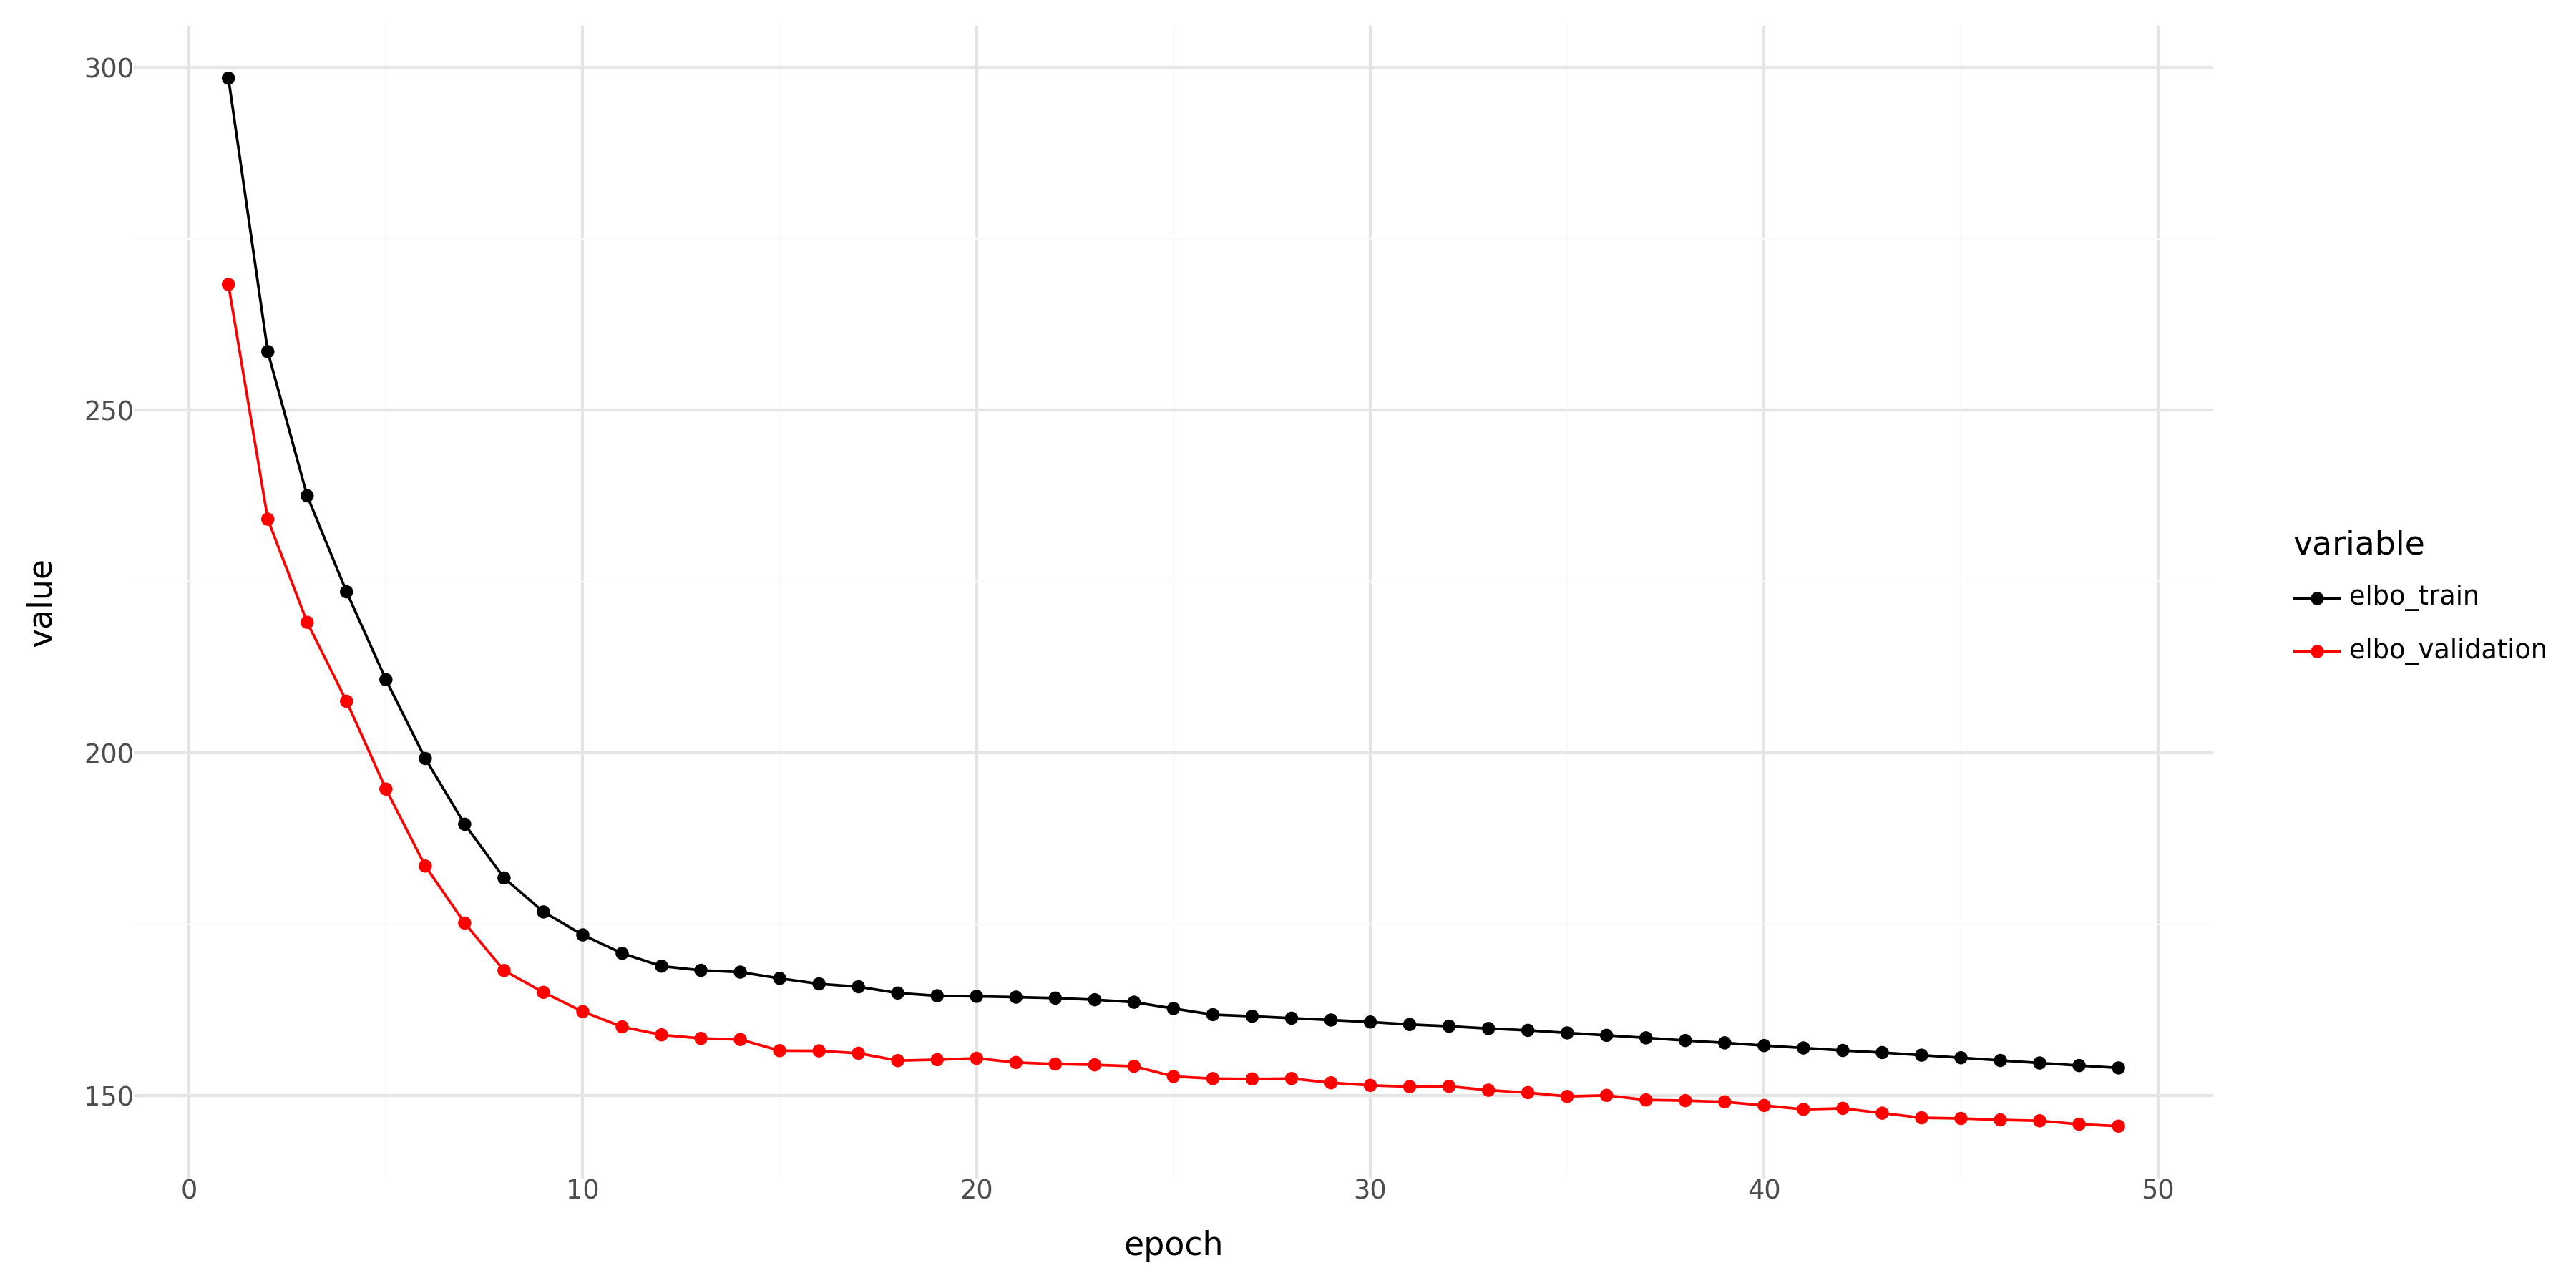

In [32]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- Extract latent representation

In [27]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [28]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/epithelial_scRNA_and_Xenium_add_on_scANVI.h5ad')

+ Visualize dataset

In [29]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:16)


In [30]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/epithelial_scRNA_and_Xenium_add_on_scANVI.h5ad')

In [ ]:
sc.set_figure_params(dpi=300, figsize=(10,7))
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'C_scANVI', 'Library_Preparation_Protocol', 'Donor_ID'], ncols = 3, frameon = False, size = 1)